In [1]:
import torch
from torch import nn
import torchaudio
import numpy as np
from sklearn.neighbors import NearestNeighbors as KNN
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa import display
import re
import os
import math
from collections import Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class Text2Speech(object):
    def __init__(self, audio_path, text_path, n_mels=80, n_features=1024, hop_length=256):

        self.audio_path = audio_path
        self.text_path = text_path
        self.n_features = n_features
        self.hop_length = hop_length
        self.n_mels = n_mels

        self.phrases = self._get_phrases()

        self.text_length = self._get_text_length()

        self.words = self._get_words(self.phrases)
        self.letters = self._get_letters(self.words)

        self.dictionary = self._create_dictionary(self.letters)
        self._normalize(self.dictionary)

        self.tokens = self._encode_letters()

        self.text_data = None
        self.sample_rate = None
        self.audio_length = None
        self.audio_data = self._create_audio_data()
        self.spectrograms = self._create_spectrograms()
        
        
    def create_data(self):
        text_data = torch.from_numpy(self.tokens)

        text_data = text_data.unsqueeze(-1)

        self.text_data = text_data

        print(f"Text Data Size: {self.text_data.size()}")

    def detokenize(self, data, reference_dict):
        data = data.cpu().numpy()
        values = list(reference_dict.values())

        values = np.array(values).reshape(-1,1)

        knn = KNN(n_neighbors=1, algorithm='kd_tree').fit(values)

        _, index = knn.kneighbors(data)

        keys = list(reference_dict.keys())

        words = []

        for subarray in index:
            for i in subarray:
                words.append(keys[i])

        words = [item for item in words if item != "<EOS>"]
        
        phrase = ''.join(words)

        return phrase, words
        

    def __len__(self):

        return len(self.text_data)

    def __getitem__(self, idx):

        audio = self.audio_data[idx]
        spectrograms = self.spectrograms[idx]
        text = self.text_data[idx]

        return audio, spectrograms, text


    def _create_audio_data(self):
        audio_files = []

        for directory, _, files in os.walk(self.audio_path):
            for file in files:
                audio_files.append(directory+'/'+file)

        audio_files = [i for i in audio_files if '.wav' in i]

        audio_data_preprocessed = []

        for audio in audio_files:
            data, sr = torchaudio.load(audio)
            audio_data_preprocessed.append(data.numpy())

        length = [x.shape[1] for x in audio_data_preprocessed]
        self.audio_length = max(length)
        self.sample_rate = sr

        audio_data = []
        
        for i in range(len(audio_data_preprocessed)):
            audio = audio_data_preprocessed[i]
            audio_size = audio.shape[1]
            
            if audio_size < self.audio_length:
                pad_size = self.audio_length - audio_size
                audio = np.pad(audio, [(0, 0), (0, pad_size)])

            audio_data.append(audio)

        audio_data = np.array(audio_data)
        audio_data = np.stack(audio_data, 0)
        audio_data = torch.from_numpy(audio_data)

        print(f"Audio dataset size: {audio_data.size()}")

        return audio_data

    def _create_spectrograms(self):

        transformer = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=self.n_mels,
            n_fft=self.n_features,
            hop_length=self.hop_length,
            win_length=self.n_features
        )

        audio_dataset = []

        for i in range(len(self.audio_data)):
            data = transformer(self.audio_data[i])
            audio_dataset.append(data.numpy())

        audio_dataset = np.array(audio_dataset) # Using Numpy because Pytorch's stack is rubbish
        audio_dataset = np.stack(audio_dataset, 0)

        audio_dataset = torch.from_numpy(audio_dataset)

        # The LSTM expects to receive input with shapes (Batch, Timesteps, Features), so we have to transpose our features and remove the Channels size

        # HOWEVER....we should consider using MultiAttention blocks

        audio_dataset = audio_dataset.view(audio_dataset.size(0), audio_dataset.size(3), audio_dataset.size(2))

        return audio_dataset

    def _get_phrases(self):
        script_files = []

        for directory, _, files in os.walk(self.text_path):
            for file in files:
                script_files.append(directory+'/'+file)

        script_files = [i for i in script_files if '.txt' in i]

        text_data_preprocessed = []

        for item in script_files:
            file = open(item, 'r')
            for i in file:
                text_data_preprocessed.append(str(i))
    
            file.close()

        text_data_preprocessed = [x.lower() for x in text_data_preprocessed]
        phrases = [re.sub('[^a-z0-9\s\.\!\,\?]', '', x) for x in text_data_preprocessed]

        return phrases

    def _get_words(self, phrases):
        words = ' '.join(phrases)
        words = words.split(' ')

        return words

    def _get_letters(self, words):
        letters = ' '.join(words)
        letters = ''.join(letters.split())
        letters = [i for i in letters]

        return letters

    def _create_dictionary(self, words):
        idx2word = []
        word2idx = {}
        for word in words:
            if word not in word2idx:
                idx2word.append(word)
                word2idx[word] = len(idx2word) - 1
        
        word2idx[' '] = len(idx2word)
        word2idx['.'] = len(idx2word) + 1
        word2idx[' ! '] = len(idx2word) + 2
        word2idx[', '] = len(idx2word) + 3
        word2idx['?'] = len(idx2word) + 4

        word2idx['<EOS>'] = len(idx2word) + 5

        return word2idx

    def _normalize(self, dictionary):
        maximum = max(dictionary.values())

        for word, value in dictionary.items():

            scaled_value = (value-0)*2.0 / (maximum - 0)-1.0

            dictionary[word] = scaled_value

    def _get_text_length(self):

        maximum_length = 0
        
        for sentence in self.phrases:
            word_length = 0

            for character in sentence:
                word_length += len(character)

            sentence_length = word_length

            if sentence_length > maximum_length:
                maximum_length = sentence_length

        return maximum_length
    
    def _encode_letters(self):
        
        phrases = [x.split() for x in self.phrases]
        

        tokens = []


        for sentence in phrases:
            tokenized_sentence = []

            for word in sentence:
                tokenized_word = []

                for character in word:

                    value = self.dictionary.get(character)

                    tokenized_sentence.append(value)
                
                value = self.dictionary.get(' ')
                tokenized_sentence.append(value) # After each word, add a space.
            
            tokenized_sentence = np.array(tokenized_sentence)

            sentence_size = tokenized_sentence.shape[0]

            if sentence_size < self.text_length+1:
                pad_size = self.text_length+1 - sentence_size
                tokenized_sentence = np.pad(tokenized_sentence, [(0, pad_size)], constant_values=1.0)

            tokens.append(tokenized_sentence)
        
        tokens = np.array(tokens)

        return tokens

In [4]:
AUDIO_PATH = "D:/Python/Audio/English/"
TEXT_PATH = "D:/Python/Audio/Script/"

In [5]:
dataset = Text2Speech(AUDIO_PATH, TEXT_PATH)

Audio dataset size: torch.Size([149, 1, 341087])


In [29]:
print(dataset.audio_data[10])

tensor([[ 0.0000e+00, -3.0518e-05,  6.1035e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [14]:
print(dataset.spectrograms.size())

torch.Size([149, 1333, 80])


In [7]:
print(dataset.audio_length)

341087


In [8]:
print(dataset.text_length)

76


In [6]:
dataset.create_data()

Text Data Size: torch.Size([149, 77, 1])


In [10]:
print(len(dataset.text_data))

149


In [ ]:
print(dataset.phrases)

In [ ]:
print(dataset.words)

In [ ]:
print(dataset.letters)

In [12]:
print(dataset.dictionary)

{'s': -1.0, 'o': -0.9411764705882353, ',': -0.8823529411764706, 't': -0.8235294117647058, 'h': -0.7647058823529411, 'i': -0.7058823529411764, 'c': -0.6470588235294117, 'a': -0.5882352941176471, 'm': -0.5294117647058824, 'e': -0.47058823529411764, 'f': -0.4117647058823529, 'r': -0.3529411764705882, 'v': -0.2941176470588235, 'n': -0.23529411764705888, '.': 0.7647058823529411, 'l': -0.11764705882352944, 'w': -0.05882352941176472, 'd': 0.0, 'p': 0.05882352941176472, '?': 0.9411764705882353, 'k': 0.17647058823529416, '!': 0.23529411764705888, 'j': 0.2941176470588236, 'y': 0.3529411764705883, 'u': 0.41176470588235303, 'g': 0.47058823529411775, 'b': 0.5294117647058822, 'z': 0.588235294117647, 'q': 0.6470588235294117, ' ': 0.7058823529411764, ' ! ': 0.8235294117647058, ', ': 0.8823529411764706, '<EOS>': 1.0}


In [13]:
print(dataset.tokens[0])

[-1.         -0.94117647 -0.88235294  0.70588235 -0.82352941 -0.76470588
 -0.70588235 -1.          0.70588235 -0.64705882 -0.58823529 -0.52941176
 -0.47058824  0.70588235 -0.41176471 -0.35294118 -0.94117647 -0.52941176
  0.70588235 -0.82352941 -0.76470588 -0.47058824  0.70588235 -0.76470588
 -0.47058824 -0.58823529 -0.29411765 -0.47058824 -0.23529412 -1.
  0.76470588  0.76470588  0.76470588  0.70588235  1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.        ]


In [ ]:
print(dataset.text_data[0])

In [8]:
teste, teste2 = dataset.detokenize(dataset.text_data[0], dataset.dictionary)
print(teste)

so, this came from the heavens... 


In [ ]:
# Time to create the model
# Remember: The idea is not using LSTMs. We can use them for starters, but that shouldn't be our final model
# Our input should be text. In order to replace LSTMs, we could use MultiAttentionHeads from Transformer
# Our output should be audio. WaveGlow inserts Spectrograms directly into the final layer in order to condition the output
# The output have shape (1, data), so it can be converted to a waveform


# In order to generate words spontaneously, we'll probably need a Text GAN
# For that, we could use LSTMs, or, Attention Layers
# We could use a transformer(or even BERT itself) to generate words and we could also use a discriminator.
# This discriminator will distinguish between fake and true texts.
# How can this discriminator distinguish between nonsense and (with)sense texts? ----> Bleu score
# https://aclanthology.org/P02-1040.pdf
# The Bleu score takes an input text and a reference text. The input text will the the one generated by the GAN. The reference, our original data.
# After generating the text, we pass it to the voice generator.

In [7]:
class BleuScore:
    """
    Using a separate class because Pytorch's autograd is rubbish

    BleuScore Function adapted to be used in backpropagation. Adapted from https://stackoverflow.com/questions/56968434/bleu-score-in-python-from-scratch


    The input tensors are converted to strings so the n-grams can be extracted and the Bleu Score measured.

    Args:
        candidate_sentence: Tensor of shape (sentence_length, ) containing the values which corresponds to each token.
        target_sentence: Tensor of shape (length, ) which will be used as reference.
        max_n: The maximum n-gram we'll use. E.g. if max_n=3, we'll use unigrams, bigrams and trigrams.
            For compatibility reasons, the max_n must be equal to or smaller than sentence_length
            Default = 4
        weights: a list of weights to be used for each n_gram category (uniform by default).
        dictionary: a dictionary to be used for translating the tensors into strings.
    """

    def __init__(self, max_n=4, weights=[0.25]*4, dictionary=dataset.dictionary):

        self.max_n = max_n
        self.weights = weights
        self.dictionary = dictionary


    def _n_gram_generator(self, sentence, n=2,remove_repeating=False):

        sentence = sentence.lower() # converting to lower case
        sent_arr = np.array(sentence.split()) # split to string arrays
        length = len(sent_arr)

        word_list = []
        for i in range(length+1):
            if i < n:
                continue
            word_range = list(range(i-n,i))
            s_list = sent_arr[word_range]
            string = ' '.join(s_list) # converting list to strings
            word_list.append(string) # append to word_list
            if remove_repeating:
                word_list = list(set(word_list))
        return word_list

    
    def bleu_score(self, original,machine_translated):
        '''
        Bleu score function given an original and a machine translated sentences
        '''

        original, _ = dataset.detokenize(original, self.dictionary)

        machine_translated, _ = dataset.detokenize(machine_translated, self.dictionary)


        mt_length = len(machine_translated.split())
        o_length = len(original.split())

        # Brevity Penalty 
        if mt_length>o_length:
            BP=1
        else:
            penality=1-(mt_length/o_length)
            BP=np.exp(penality)

        # Clipped precision
        clipped_precision_score = []

        for i in range(1, self.max_n+1):
            original_n_gram = Counter(self._n_gram_generator(original,i))
            machine_n_gram = Counter(self._n_gram_generator(machine_translated,i))

            counter = len(machine_n_gram.values())

            if counter == 0:
                counter += 1
            
            for j in machine_n_gram:
                if j in original_n_gram:
                    if machine_n_gram[j] > original_n_gram[j]:
                        machine_n_gram[j] = original_n_gram[j]
                else:
                    machine_n_gram[j] = 0

            clipped_precision = sum(machine_n_gram.values())/counter
            clipped_precision_score.append(clipped_precision)

        weights = self.weights

        scores = []
        dscores = []

        for weight, precision in zip(weights, clipped_precision_score):
            w_i = weight
            p_i = precision

            if p_i == 0.0:
                score = (w_i * math.log(0.0001)) # Log of 0 tends to -infinite. But let's just stick to 0.0001 so a single wrong word won't break the score.
                                                # Since log of 0.0001 = -9.21, which is also a quite big negative number(?)
                dscore = (w_i/math.log(0.0001)) # Again, a division by -infinite would result in 0, which would also break the derivative.

            else:
                score = (w_i * math.log(p_i))

                if p_i != 1.0:
                    dscore = (w_i/math.log(p_i))
                else:
                    dscore = 0
        
            scores.append(score)
            dscores.append(dscore)

        score = BP * math.exp(math.fsum(scores))

        gradients = []

        for i in dscores:
            derivative = BP * math.exp(math.fsum(scores)) * len(scores) * i

            # When the candidate sentence is too small, the BP causes the derivative to be too small. The result is, we can get
            # a derivative that is bigger for small yet completely wrong sentences than the derivative for a bigger yet almost correct sentence
            # i.e: reference: "so, this is how the sea smells..."
            # candidate 1: "so, this is how the sea shells..." ---> derivative = -2.78
            # candidate 2: "panda" ---> derivative = -9e-5
            # So we're gonna use a correction factor to avoid this, which is simply applying a log 10

            if derivative != 0.0:

                correction_factor = math.log10(abs(derivative))

                if correction_factor > 0:
                    correction_factor = -correction_factor

                derivative = correction_factor

            gradients.append(derivative)

        return score, gradients

In [8]:
class BleuScoreLoss(torch.autograd.Function):
    """
    The BleuScore adapted to be a Loss Function in Pytorch.
    Bear in mind that the gradients output in the backward method must have the same shape as the input in the forward method
    (the function input).
    For this motive, the number of n-grams is the same as the sentence_length in the input.

    Args:

        input: The candidate sentence, being an tensor with size (sentence_length, 1)
        target: The reference sentence, a tensor with size (sentence_length', 1). Can have a different length than the input.
        weights: the weights to be applied for each n-gram.
    """
    
    @staticmethod
    def forward(ctx, input, target, weights=[0.25]):

        max_n = input.size(0)
        weights = weights * max_n

        functional = BleuScore(max_n, weights)

        score, derivative = functional.bleu_score(target, input)

        score, derivative = torch.tensor(score, device=device), torch.tensor(derivative, device=device)

        ctx.save_for_backward(derivative)

        return score

    @staticmethod
    def backward(ctx, grad_output):

        derivative, = ctx.saved_tensors
        derivative = derivative.unsqueeze(-1)

        output = grad_output*derivative
        output = output.to(device) # Just to make sure. Gradients returned in a different device will throw an error.

        return output, None

In [9]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_heads, d_queries, d_values, dropout, in_decoder=False):

        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_keys = d_values # size of key vectors, same as of the query vectors to allow dot-products for similarity
        self.dropout = dropout

        self.in_decoder = in_decoder

        self.create_queries = nn.Linear(d_model, n_heads*d_queries, bias=False)
        self.create_values = nn.Linear(d_model, n_heads*d_values, bias=False)
        self.create_keys = nn.Linear(d_model, n_heads*d_values, bias=False)

        self.softmax = nn.Softmax(dim=-1)

        self.layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

        self.cast_output = nn.Linear(n_heads*d_values, d_model, bias=False)

    def forward(self, query_sequences, key_sequences, value_sequences):

        batch_size = query_sequences.size(0)
        query_sequences_length = query_sequences.size(1)

        self_attention = torch.equal(key_sequences, query_sequences)

        residual = query_sequences

        query_sequences = self.layer_norm(query_sequences)

        if self_attention:
            key_sequences = self.layer_norm(key_sequences)
            value_sequences = self.layer_norm(value_sequences)

        queries = self.create_queries(query_sequences)
        keys = self.create_keys(key_sequences)
        values = self.create_values(value_sequences)

        queries = queries.contiguous().view(batch_size, query_sequences_length, self.n_heads, self.d_queries)
        queries = queries.permute(0, 2, 1, 3).contiguous().view(batch_size*self.n_heads, query_sequences_length, self.d_queries)

        keys = keys.contiguous().view(batch_size, query_sequences_length, self.n_heads, self.d_keys)
        keys = keys.permute(0, 2, 1, 3).contiguous().view(batch_size*self.n_heads, query_sequences_length, self.d_keys)

        values = values.contiguous().view(batch_size, query_sequences_length, self.n_heads, self.d_values)
        values = values.permute(0, 2, 1, 3).contiguous().view(batch_size*self.n_heads, query_sequences_length, self.d_values)


        dotproduct = torch.bmm(queries, keys.permute(0, 2, 1))

        dotproduct = dotproduct/(math.sqrt(self.d_keys))


        if self.in_decoder and self_attention:
            not_future_mask = torch.ones_like(dotproduct).tril().bool().to(device)

            attention_weights = dotproduct.masked_fill(~not_future_mask, -float('inf'))

        attention_weights = self.softmax(dotproduct)

        attention_weights = self.dropout(attention_weights)

        sequences = torch.bmm(attention_weights, values)

        sequences = sequences.view(batch_size, query_sequences_length, -1)

        sequences = self.cast_output(sequences)

        sequences = self.dropout(sequences)

        output = sequences + residual

        return output

In [10]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, d_inner, dropout):

        super(PositionWiseFeedForward, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner

        self.layer_norm = nn.LayerNorm(d_model)

        self.neuron1 = nn.Linear(d_model, d_inner)

        self.Relu = nn.ReLU()

        self.neuron2 = nn.Linear(d_inner, d_model)

        self.dropout = nn.Dropout(dropout)


    def forward(self, sequences):

        residual = sequences

        sequences = self.layer_norm(sequences)

        sequences = self.neuron1(sequences)
        sequences = self.Relu(sequences)
        sequences = self.dropout(sequences)

        sequences = self.neuron2(sequences)
        sequences = self.dropout(sequences)

        output = sequences + residual

        return output

In [11]:
class Encoder(nn.Module):
    """
    Input: (1, 77, 1) = (Batch, n_timesteps, n_features[character]).
    Our data here is composed of (Batch, n_characters, character), and each batch is equivalent to an entire sentence.

    Encoder output: (1, 77, positional_encoding) ----> Encoding, just like one-hot encoding, label-encoding...
    Perhaps this is why BERT, using just the Encoder, can be used as a classifier.
    """

    def __init__(self, positional_encoding, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Encoder, self).__init__()

        self.positional_encoding = positional_encoding
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.positional_encoding.requires_grad = False

        self.encoder_layers = nn.ModuleList([self.make_encoder_layer() for i in range(n_layers)])

        self.dropout = nn.Dropout(self.dropout)

        self.layer_norm = nn.LayerNorm(d_model)

    def make_encoder_layer(self):
        encoder_layer = nn.ModuleList([MultiHeadAttention(d_model=self.d_model,
                                                          n_heads=self.n_heads,
                                                          d_queries=self.d_queries,
                                                          d_values=self.d_values,
                                                          dropout=self.dropout,
                                                          in_decoder=False),
                                       PositionWiseFeedForward(d_model=self.d_model,
                                                             d_inner=self.d_inner,
                                                             dropout=self.dropout)])

        return encoder_layer

    def forward(self, encoder_sequences):

        encoder_sequences = encoder_sequences * math.sqrt(self.d_model) + self.positional_encoding.to(device)

        encoder_sequences = self.dropout(encoder_sequences)

        for layer in self.encoder_layers:

            encoder_sequences = layer[0](query_sequences=encoder_sequences, key_sequences=encoder_sequences, value_sequences=encoder_sequences)
            
            encoder_sequences = layer[1](sequences=encoder_sequences)

        encoder_sequences = self.layer_norm(encoder_sequences)

        return encoder_sequences

In [12]:
class Decoder(nn.Module):
    """
    Decoder input: Encoder output: (1, 77, positional_encoding)
    Decoder output: (1, 77, 1) = (Batch, n_timesteps, n_features[character])

    This is what will generate our sentence. Since I won't be using word embedding nor integer-encoding, this structure is essential, simulating the output
    of a LSTM...but with less risk of vanishing gradients.
    """

    def __init__(self, positional_encoding, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Decoder, self).__init__()

        self.positional_encoding = positional_encoding
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.positional_encoding.requires_grad = False

        self.decoder_layers = nn.ModuleList([self.make_decoder_layer() for i in range(n_layers)])

        self.dropout = nn.Dropout(self.dropout)

        self.layer_norm = nn.LayerNorm(d_model)

        self.neuron = nn.Linear(d_model, 1)

    def make_decoder_layer(self):

        decoder_layer = nn.ModuleList([MultiHeadAttention(d_model=self.d_model,
                                                          n_heads=self.n_heads,
                                                          d_queries=self.d_queries,
                                                          d_values=self.d_values,
                                                          dropout=self.dropout,
                                                          in_decoder=True),
                                       MultiHeadAttention(d_model=self.d_model,
                                                          n_heads=self.n_heads,
                                                          d_queries=self.d_queries,
                                                          d_values=self.d_values,
                                                          dropout=self.dropout,
                                                          in_decoder=True),
                                       PositionWiseFeedForward(d_model=self.d_model,
                                                             d_inner=self.d_inner,
                                                             dropout=self.dropout)])

        return decoder_layer

    def forward(self, decoder_sequences, encoder_sequences):

        decoder_sequences = decoder_sequences * math.sqrt(self.d_model) + self.positional_encoding.to(device)

        decoder_sequences = self.dropout(decoder_sequences)

        for layer in self.decoder_layers:

            decoder_sequences = layer[0](query_sequences=decoder_sequences, key_sequences=decoder_sequences, value_sequences=decoder_sequences)

            decoder_sequences = layer[1](query_sequences=decoder_sequences, key_sequences=encoder_sequences, value_sequences=encoder_sequences)

            decoder_sequences = layer[2](sequences=decoder_sequences)

        decoder_sequences = self.layer_norm(decoder_sequences)

        output = self.neuron(decoder_sequences)

        return output

In [13]:
class Transformer(nn.Module):

    def __init__(self, positional_encoding, d_model=512, n_heads=8, d_queries=64, d_values=64, d_inner=2056, n_layers=6, dropout=0.1):

        super(Transformer, self).__init__()

        self.positional_encoding = positional_encoding
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.encoder = Encoder(positional_encoding=positional_encoding,
                               d_model=d_model,
                               n_heads=n_heads,
                               d_queries=d_queries,
                               d_values=d_values,
                               d_inner=d_inner,
                               n_layers=n_layers,
                               dropout=self.dropout)

        self.decoder = Decoder(positional_encoding=positional_encoding,
                               d_model=d_model,
                               n_heads=n_heads,
                               d_queries=d_queries,
                               d_values=d_values,
                               d_inner=d_inner,
                               n_layers=n_layers,
                               dropout=self.dropout)
                               
    def forward(self, encoder_sequences, decoder_sequences):

        encoder_sequences = self.encoder(encoder_sequences)

        decoder_sequences = self.decoder(decoder_sequences, encoder_sequences)

        return decoder_sequences

In [14]:
def get_positional_encoding(d_model, max_length=100):
    """
    Computes positional encoding as defined in the paper.
    :param d_model: size of vectors throughout the transformer model
    :param max_length: maximum sequence length up to which positional encodings must be calculated
    :return: positional encoding, a tensor of size (1, max_length, d_model)
    """
    positional_encoding = torch.zeros((max_length, d_model))  # (max_length, d_model)
    for i in range(max_length):
        for j in range(d_model):
            if j % 2 == 0:
                positional_encoding[i, j] = math.sin(i / math.pow(10000, j / d_model))
            else:
                positional_encoding[i, j] = math.cos(i / math.pow(10000, (j - 1) / d_model))

    positional_encoding = positional_encoding.unsqueeze(0)  # (1, max_length, d_model)

    return positional_encoding

In [15]:
positional_encoding = get_positional_encoding(d_model=16, max_length=77)

print(positional_encoding.size())

torch.Size([1, 77, 16])


In [ ]:
# The Transformer input is (batch_size, n_timesteps, n_features), just like a LSTM. Remember that each batch will contain a time_step, which will contain a single
# character. So a single batch is a sequence of time_steps, which will compose a sentence.

# Would it be interesting to generate random, gaussian noise with that shape and directly pass it through the transformer?
# Or would it be better if we generate a random noise, pass it through some convolution layers and reshape the output into (batch_size, n_timesteps, n_features)
# only for, then, pass it into the transformer?

# If we decide to use convolutions...would it be better if we use a Conv1D with noise inputs (batch_size, 500, 100) and output (batch, n_timesteps, 1), or would it
# be better if we simply use neurons, with noise input (batch_size, 500*100)?

# https://stackoverflow.com/questions/55576314/conv1d-with-kernel-size-1-vs-linear-layer
# Conv1Ds involves more operations, thus is considerably slower and more computationally expensive. It's slightly more accurated, but it doesn't seem to be really worth it.
# Sticking to Linear layers.

# Remember: Our labels have shape (Batch, 77, 1). This must be our output in the end.

# The generator can be optimized by using our BleuScore Loss. This could, perhaps, make the discriminator disposable. Or, we could combine the 2 things?

# The discriminator. It'll receive a sentence as input. If each time_step correspond to a single character, then a data composed of complete sentences will have no time_step.
# Thus, the discriminator input will have shape (batch_size, 1). Then, it'll proceed to classify the sentence between real or false. The classic thing.
# BERT can use the Transformer's Encoder to classify sentences, too. However, this would require creating sentences sequences. Let's try the classic one first.

In [16]:
class Broca(nn.Module):
    """
    The generator, which will generate the words that she'll speak.
    """

    def __init__(self, positional_encoding, d_transformer=512, n_heads=8, d_queries=64, d_values=64, d_inner=2056, n_layers=6, dropout=0.1):

        super(Broca, self).__init__()

        self.sequence_length = positional_encoding.size(1)
        self.positional_encoding = positional_encoding
        self.d_transformer = d_transformer
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout


        self.neurons1 = nn.Linear(500*100, self.sequence_length, bias=False)
        self.tanh = nn.Tanh()

        self.transformer = Transformer(
            positional_encoding=self.positional_encoding,
            d_model=self.d_transformer,
            n_heads=self.n_heads,
            d_queries=self.d_queries,
            d_values=self.d_values,
            d_inner=self.d_inner,
            n_layers=self.n_layers,
            dropout=self.dropout
        )

    def forward(self, input, target):

        input = input.view(input.size(0), -1)

        x = self.neurons1(input)
        x = self.tanh(x)

        x = x.view(input.size(0), self.sequence_length, -1)

        output = self.transformer(x, target)

        return output

In [17]:
class Wernicke(nn.Module):
    """
    The discriminator, which will receive the words that she must learn, and also check if the words
    she's speaking are close to what we speak or not.
    """

    def __init__(self):

        super(Wernicke, self).__init__()

        self.neuron1 = nn.Linear(77, 100, bias=False)
        self.neuron2 = nn.Linear(100, 100, bias=False)
        self.neuron3 = nn.Linear(100, 1, bias=False)

        self.layer_norm = nn.LayerNorm(100)

        #self.dropout = nn.Dropout(0.25)
        self.ReLU = nn.ReLU()

    
    def forward(self, input):

        input = input.view(input.size(0), -1)

        x = self.neuron1(input)
        x = self.layer_norm(x)
        x = self.ReLU(x)

        x = self.neuron2(x)
        x = self.layer_norm(x)
        x = self.ReLU(x)

        output = self.neuron3(x)

        return output
        

In [18]:
costsD = []
costsG = []
Glearning_rate = []
Dlearning_rate = []
Dgrads = [] # To check if there's vanishing/exploding gradients
Ggrads = []

In [99]:
def train_TextGAN(
    dataset=None,
    batch_size=16,
    epochs=1000,
    checkpoint=100,
    lr=1e-5,
    beta=1e-3,
    grad_clip=None,
    save_path=None,
    d_transformer=512,
    n_heads=8,
    d_queries=64,
    d_values=64,
    d_inner=2056,
    n_layers=6,
    dropout=0.1
):

    Speak = Broca(positional_encoding, d_transformer, n_heads, d_queries, d_values, d_inner, n_layers, dropout).to(device).double()

    Recognize = Wernicke().to(device).double()

    if save_path is None:

        start_epoch = 0

        for name, param in Speak.named_parameters():
            if "weight" in name:
                nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                nn.init.constant_(param, 0.0)

        for name, param in Speak.named_parameters():
            if "weight" in name:
                nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                nn.init.constant_(param, 0.0)

    else:

        params = torch.load(f"{save_path}/Alice_checkpoint.json")

        start_epoch = params['Epoch'] + 1
        Speak.load_state_dict(params['Generator_Params'])
        Recognize.load_state_dict(params['Discriminator_Params'])
        lr = params['Discriminator_LR']

        print(f"\nLoaded checkpoint from epoch {start_epoch}")

    Goptim = torch.optim.AdamW(Speak.parameters(), lr=lr*5e5, betas=(0.9, 0.999), eps=1e-9, weight_decay=0)
    Gscheduler = torch.optim.lr_scheduler.StepLR(Goptim, 1, gamma=0.1)

    Doptim = torch.optim.AdamW(Recognize.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9, weight_decay=0)
    Dscheduler = torch.optim.lr_scheduler.StepLR(Doptim, 10, gamma=0.1)

    # In SRGAN, content_loss + (beta * adversarial_loss) = perceptual_loss ---> the adversarial loss updates the discriminator, and the perceptual, the generator

    adversarial_loss = nn.BCEWithLogitsLoss().double()
    content_loss = BleuScoreLoss()
    beta = beta


    # Instead of assigning 1 for real label and 0 for fake, assigning numbers that are close to 1 and 0 ---> label-smoothing.

    real_label = 0.9
    fake_label = 0.

    Speak.train()
    Recognize.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):

        for i, (_, _, text) in enumerate(dataloader):

            text = text.to(device)

            # text shape = (batch, 77, 1)

            random_noise = torch.normal(0, 0.05, size=text.size(), device=device, dtype=torch.double)

            text = text + random_noise # Adding random noise to both real and fake input in order to avoid collapse and facilitate convergence

            Recognize.zero_grad()

            labels = torch.full((text.size(0),), real_label, dtype=torch.double, device=device) # Shape = (batch)

            Doutput = Recognize(text) # Doutput shape = (batch, 1)

            Doutput = Doutput.view(-1) # Doutput shape = (batch)

            errorD_real = adversarial_loss(Doutput, labels)

            errorD_real.backward()

            noise = torch.normal(0, 1000, size=(text.size(0), 500*100, 1), device=device, dtype=torch.double) # Maybe using a higher std might avoid Gen's vanishing gradients
            
            fake_phrases = Speak(noise, text) # Phrases shape = (batch, 77, 1)

            labels = labels.fill_(fake_label)

            fake_phrases = fake_phrases + random_noise

            Doutput = Recognize(fake_phrases.detach())

            Doutput = Doutput.view(-1)

            errorD_fake = adversarial_loss(Doutput, labels)

            errorD_fake.backward()

            errorD = errorD_real + errorD_fake

            costsD.append(errorD.item())

            for p in Recognize.parameters():
                g = p.clone()

                Dgrads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            Doptim.step()


            Speak.zero_grad()

            Dlabels = Recognize(fake_phrases)

            Dlabels = Dlabels.view(-1)

            labels.fill_(real_label)

            adversarial_cost = adversarial_loss(Dlabels, labels)

            # Our tokenizer's KNN can only accept input with 2 dimmensions. So we'll be passing each batch into the BleuLoss and use their mean.

            content_cost = 0

            for batch in range(len(fake_phrases)):

                content_cost += content_loss.apply(fake_phrases[batch], text[batch])

            content_cost = content_cost/len(fake_phrases)

            perceptual_loss = content_cost + (adversarial_cost * beta)

            perceptual_loss.backward()

            costsG.append(perceptual_loss.item())

            for p in Speak.parameters():
                g = p.clone()

                Ggrads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            Goptim.step()


            best_disc_loss = float('inf')
            best_gen_loss = float('inf')

            if errorD.item() < best_disc_loss:

                best_disc_loss = errorD.item()
                best_disc_params = Recognize.state_dict()

            if perceptual_loss.item() < best_gen_loss:

                best_gen_loss = perceptual_loss.item()
                best_gen_params = Speak.state_dict()

            
            if i % checkpoint == 0:

                print(f"{epoch}/{epochs}")
                print(f"Best Discriminator Loss: {best_disc_loss}\tCurrent LR: {Dscheduler.get_last_lr()[0]}\tGrads Average: {Dgrads[-1]}")
                print(f"Best Generator Loss: {best_gen_loss}\tCurrent LR: {Gscheduler.get_last_lr()[0]}\tGrads Average: {Ggrads[-1]}")

                if save_path is None:
                    try:
                        os.mkdir("Alice")
                        save_path = "Alice"
                    except:
                        save_path = "Alice"
                        
                torch.save({
                    'Epoch': epoch,
                    'Generator_Params': best_gen_params,
                    'Generator_LR': Gscheduler.get_last_lr()[0],
                    'Discriminator_Params': best_disc_params,
                    'Discriminator_LR': Dscheduler.get_last_lr()[0]
                }, f"{save_path}/Alice_checkpoint.json")

                print("Models saved!")

                with torch.no_grad():

                    sample_text = Speak(noise, text)

                    with open(f"{save_path}/sample_text_{epoch}.txt", 'w+') as f:
                        for batch in range(len(sample_text)):
                            sentence, _ = dataset.detokenize(sample_text[batch], dataset.dictionary)

                            f.write(sentence)
                            f.write('\n')

                    #f.close()
                
                print("Samples saved!")
            
            f.close()

        
        Gscheduler.step()
        Dscheduler.step()

        Glearning_rate.append(Gscheduler.get_last_lr()[0])
        Dlearning_rate.append(Dscheduler.get_last_lr()[0])

In [47]:
train_TextGAN(
    dataset=dataset,
    batch_size=4,
    epochs=5,
    checkpoint=100,
    lr=1e-5,
    beta=1e-3,
    grad_clip=1.0,
    save_path=None,
    d_transformer=16,
    n_heads=2,
    d_queries=4,
    d_values=4,
    d_inner=32,
    n_layers=2,
    dropout=0.1
)

0/5
Best Discriminator Loss: 1.590544018086319	Current LR: 1e-05	Grads Average: 0.0
Best Generator Loss: 0.0006285470264459421	Current LR: 5.0	Grads Average: 0.0
Models saved!
Samples saved!
1/5
Best Discriminator Loss: 1.3094553423955126	Current LR: 1e-05	Grads Average: -2.274737345670894e-06
Best Generator Loss: 0.0007421080758653822	Current LR: 0.5	Grads Average: 29.516257034547124
Models saved!
Samples saved!
2/5
Best Discriminator Loss: 1.3046392231380162	Current LR: 1e-05	Grads Average: 4.09221978192605e-06
Best Generator Loss: 0.0008112323117914499	Current LR: 0.05	Grads Average: 29.603664904172756
Models saved!
Samples saved!
3/5
Best Discriminator Loss: 1.272027541633915	Current LR: 1e-05	Grads Average: 1.7739951751202434e-05
Best Generator Loss: 0.0008751492644046873	Current LR: 0.005000000000000001	Grads Average: 29.607049909543697
Models saved!
Samples saved!
4/5
Best Discriminator Loss: 1.0827107356696406	Current LR: 1e-05	Grads Average: 4.2266294865712174e-05
Best Generat

In [53]:
from torch.utils import tensorboard

Speak = Broca(positional_encoding, 16, 2, 4, 4, 32, 2, 0.1).to(device).double()

Recognize = Wernicke().to(device).double()

writer = tensorboard.SummaryWriter(log_dir='Generator', comment="Testing Alice's Text GAN")

writer.add_graph(Speak, [torch.randn((1, 50000, 1), dtype=torch.double, device=device), dataset.text_data[0].to(device)])

writer.close()

writer = tensorboard.SummaryWriter(log_dir='Discriminator', comment="Testing Alice's Text GAN")

writer.add_graph(Recognize, torch.randn((1, 77, 1)).to(device).double())

epochs=5

for epoch in range(epochs):
    for a, b, c, d, e, f in zip(costsD, costsG, Glearning_rate, Dlearning_rate, Dgrads, Ggrads):

        writer.add_scalar('Discriminator Loss', a, global_step=(epochs*140//1))
        writer.add_scalar('Generator Loss', b, global_step=(epochs*140//1))
        writer.add_scalar('Generator Learning Rate', c, global_step=(epochs*140//1))
        writer.add_scalar('Discriminator Learning Rate', d, global_step=(epochs*140//1))
        writer.add_scalar('Discriminator Gradients Average', e, global_step=(epochs*140//1))
        writer.add_scalar('Generator Gradients Average', f, global_step=(epochs*140//1))

writer.close()

In [ ]:
with open('Alice/sample_text_4.txt', 'r') as f:
    print(f.read())

In [70]:
def evaluateGAN(
    dataset=None,
    batch_size=16,
    d_transformer=512,
    n_heads=8,
    d_queries=64,
    d_values=64,
    d_inner=2056,
    n_layers=6,
    dropout=0.1,
    model_path=None
):

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    Speak = Broca(positional_encoding, d_transformer, n_heads, d_queries, d_values, d_inner, n_layers, dropout).to(device).double()

    params = torch.load(f"{model_path}/Alice_checkpoint.json")

    Speak.load_state_dict(params['Generator_Params'])

    Speak.eval()

    _, (_, _, text) = next(enumerate(dataloader))

    text = text.to(device)

    noise = torch.normal(0, 1000, size=(text.size(0), 500*100, 1), device=device, dtype=torch.double)
    
    sample_text = Speak(noise, text)

    for i in range(len(sample_text)):

        sentence, _ = dataset.detokenize(sample_text[i].detach(), dataset.dictionary)
        print(sentence)

In [71]:
evaluateGAN(
    dataset=dataset,
    batch_size=4,
    model_path="Alice",
    d_transformer=16,
    n_heads=2,
    d_queries=4,
    d_values=4,
    d_inner=32,
    n_layers=2,
    dropout=0.1
)

In [ ]:
# The GAN has been built. It needs some polishment(It only generates blank spaces), but this will do for now. Now, onward to the audio generator.
# Tacotron 2 uses as input embedding matrices which are passed into conv2d layers, with kernels 5x1. The output is batchnormalized + ReLU
# After that, it's passed into a bidirectional LSTM with 512 cells, and, then, into a Local Sensitive Attention. This word seems familiar...
# This is the encoder, which will generate vectors (batch, ). After that, the output is passed into a decoder which will try to predict Mel Spectrograms
# The decoder has 2 LSTM layers. EACH TIMESTEP of the LSTM output is then passed through 2 Linear layers, concatenated and again passed into the initial 2 LSTM layers
# This output is already a spectrogram, and part of it will be sent into the attention layer again + sigmoid activation, while another part will become a residual block
# Each timestep of that output is passed into a Conv2D layer with kernels 5x1 and this output is summed to the residual block, generating the Spectrogram

# The Spectrogram is then passed into the WaveGlow. WaveGlow is actually a GAN which generates audio from random noise conditioned by a spectrogram.
# In Tacotron training, however, instead of using random noise, it's used actually audio data squeezed to vectors, passed into a Conv1D layer with kernels 1x1
# and which weights are initialized from an orthogonal distribution (thus, being called invertible)
# Half of this layer output is passed through a WN layer which are a bunch of Conv1Ds. Some of those Conv1Ds will also include Mel Spectrograms that will condition the output.
# This output is concatenated to part of that half before, and voilá

# We could take the Text Generator output as input for our Audio Generator. Each timestep could be passed into a bunch of Transposed Conv2D layers, which will
# generate our Spectrograms.
# This generation could be conditioned by the addition of target spectrograms properly vectorized.
# We might also consider using Average/MaxPool2D...and maybe upsampling2D to avoid vanishing gradients
# After generating our spectrograms, we could convert them to audio by applying convs or vectorizing them.

# Also, WaveGlow uses convolution layers at each timestep in the audio. We could do the same ---> For time_step in (batch, 1, time_steps, features)
# Since we're using mono audio, we can make that 1 disappear. ---> (batch, time_steps, features)
# We'll be doing that for each batch ----> for time_step in (time_steps, features) ----> (features,). This way, we can use a 1D Convolution (Like WaveGlow),
# or linear layers, which are more effective

# We'll probably also need a SuperResolution model, which is used for Uberduck

In [84]:
class Vagus(nn.Module):
    """
    Receives text and spectrograms as input and outputs a waveform.
    """

    def __init__(self):

        super(Vagus, self).__init__()
        
        self.neuron1 = nn.Linear(77, 100, bias=False)
        #self.neuron2 = nn.Linear(100, 10, bias=False)
        #self.neuron3 = nn.Linear(10, 80, bias=False)
        #self.neuron4 = nn.Linear(80, 10, bias=False)
        #self.neuron5 = nn.Linear(10, 60, bias=False)
        #self.neuron6 = nn.Linear(60, 10, bias=False)
        #self.neuron7 = nn.Linear(10, 50, bias=False)
        #self.neuron8 = nn.Linear(50, 10, bias=False)
        #self.neuron9 = nn.Linear(10, 40, bias=False)
        #self.neuron10 = nn.Linear(40, 100, bias=False)
        #self.neuron11 = nn.Linear(100, 20, bias=False)
        #self.neuron12 = nn.Linear(20, 100, bias=False)
        self.neuron13 = nn.Linear(100, 100, bias=False)
        self.neuron14 = nn.Linear(100, 80, bias=False)

        self.relu = nn.ReLU() # Spectrogram values goes from 0 and beyond, so a ReLU might be quite convenient

        #self.layer_norm = nn.LayerNorm(10)
        self.layer_norm2 = nn.LayerNorm(100)

        # Linears might be a nice way to get more weights to optimize our model,
        # but they also make our model too heavy and might cause vanishing gradients

        #self.neuron15 = nn.Linear(1333*80, 1, bias=False)
        #self.neuron16 = nn.Linear(1, 1333*256, bias=False)

        self.upsampler = nn.Upsample(scale_factor=3.2, mode='nearest-exact')
        # Besides... ProGrow showed us that, perhaps, it might be good to start with few weights, and then use more as the model learns.


    def forward(self, text_input, target_spectrogram):

        batch_size = text_input.size(0)

        spectrogram_length = target_spectrogram.size(1)

        # Text ----> Extract character ----> Generate MelSpec time_step from character
        # (Batch, time_steps, 1) ----> (Batch, 1) ----> (Batch, 1, features)

        # Concatenate each MelSpec time_step generated in order to form a complete MelSpec ----> (Batch, time_steps, features) = Target Spectrogram
        # Use formed spectrogram to generate waveform: (Batch, time_steps, features) ----------> (Batch, audio_data)

        # Flatten? ----> (Batch, 1333*80) = (Batch, 106640) ----> Linear Neurons -----> (Batch, 341087) ---> Unsqueeze ---> (Batch, 1, 341087)

        mel_spec = torch.zeros_like(target_spectrogram, device=device)

        for time_step in range(spectrogram_length):

            text_feature = text_input.view(batch_size, -1) # (Batch, text_length * text_features) ---> (Batch, 76)

            text_feature = self.neuron1(text_feature) # 76*1 ----> 76*1000 -----> 76*10 ----> 76*800 ----> 76*10 ---> 76*600 ---> 76*10 ---> [...] ---> 80

            text_feature = self.relu(text_feature)

            text_feature = text_feature

            #text_feature = self.neuron2(text_feature)

            #r1 = text_feature

            #text_feature = self.layer_norm(text_feature)

            #text_feature = self.neuron3(text_feature)

            #text_feature = self.neuron4(text_feature)

            #r2 = text_feature

            #text_feature = self.layer_norm(text_feature)

            #text_feature = self.neuron5(text_feature)

            #text_feature = self.neuron6(text_feature)

            #text_feature = text_feature + r2

            #text_feature = self.layer_norm(text_feature)

            #text_feature = self.neuron7(text_feature)

            #text_feature = self.neuron8(text_feature)

            #text_feature = text_feature + r1

            #text_feature = self.layer_norm(text_feature)
            #text_feature = self.neuron9(text_feature)

            #text_feature = self.neuron10(text_feature)

            #r3 = text_feature

            #text_feature = self.layer_norm2(text_feature)

            #text_feature = self.neuron11(text_feature)

            #text_feature = self.neuron12(text_feature)

            #text_feature = text_feature + r3

            #text_feature = self.layer_norm2(text_feature)

            text_feature = self.neuron13(text_feature)

            text_feature = self.layer_norm2(text_feature)

            text_feature = self.relu(text_feature)

            text_feature = self.neuron14(text_feature)

            text_feature = self.relu(text_feature)

            mel_spec[:, time_step] += text_feature

            #del r1, r2, r3, text_feature # Freeing some memory

        mel_spec = mel_spec + target_spectrogram

        # The ideia, originally, was to pass the features from each spec time_step into a linear layer in order
        # to get 256 features. However, I failed to think on how can I concatenate it all into a single tensor with size (batch, 1, sequence*features)

        spec_features = mel_spec.view(batch_size, -1) # (Batch, 1333*80)

        #spec_features = self.neuron15(spec_features)
        #spec_features = self.neuron16(spec_features)

        audio = spec_features.view(batch_size, 1, -1) # (Batch, 1, 1333*80)

        audio = self.upsampler(audio) # (Batch, 1, 1333*256)

        # 1333*256 = 341248, and we need 341087

        output = audio[:, :, 0:341087]

        return output

In [73]:
costAudio = []
VLR = []
VGrads = []

In [108]:
def train_Vagus(
    dataset=None,
    batch_size=16,
    epochs=1000,
    checkpoint=100,
    lr=1,
    beta=1e-3,
    grad_clip=None,
    save_path=None
):

    Talker = Vagus().to(device).double()

    if save_path is None:

        start_epoch = 0

        for name, param in Talker.named_parameters():
            if "weight" in name:
                nn.init.normal_(param, 0, 0.01)
            
            if "bias" in name:
                nn.init.constant_(param, 0.0)

    else:

        params = torch.load(f"{save_path}/Alice_Voice_checkpoint.json")

        start_epoch = params['Epoch'] + 1
        Talker.load_state_dict(params['Vagus_Params'])
        lr = params['Vagus_LR']

        print(f"\nLoaded checkpoint from epoch {start_epoch}")

    Voptim = torch.optim.AdamW(Talker.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-9, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(Voptim, 1, gamma=0.1)

    # I feel that we should maybe use a log-based loss function, since Amplitudes in decibels require logs, but...meh... Maybe she'll figure it out something...

    audio_loss = nn.MSELoss()


    Talker.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):

        for i, (audio, spectrogram, text) in enumerate(dataloader):

            Talker.zero_grad()

            audio = audio.to(device).double()
            spectrogram = spectrogram.to(device).double()
            text = text.to(device).double()

            generated_audio = Talker(text, spectrogram)

            cost = audio_loss(generated_audio, audio)

            cost.backward()

            costAudio.append(cost.item())

            for p in Talker.parameters():
                g = p.clone()

                VGrads.append(torch.mean(g).item())

                if grad_clip is not None:
                    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

            Voptim.step()

            best_loss = float('inf')

            if cost.item() < best_loss:

                best_loss = cost.item()
                best_params = Talker.state_dict()

            
            if i % checkpoint == 0:

                print(f"{epoch}/{epochs}\nCurrent Loss: {cost.item()}\tBest Loss: {best_loss}\nCurrent LR: {scheduler.get_last_lr()[0]}")
                print(f"Grads Average: {VGrads[-1]}")

                if save_path is None:
                    try:
                        os.mkdir("Alice")
                        save_path = "Alice"
                    except:
                        save_path = "Alice"

                torch.save({
                    'Epoch': epoch,
                    'Vagus_Params': best_params,
                    'Vagus_LR': scheduler.get_last_lr()[0]
                }, f"{save_path}/Alice_Voice_checkpoint.json")

                print("Model saved!")

                with torch.no_grad():

                    sample_audio = Talker(text, spectrogram)

                    plt.figure(figsize=(5, 5))
                    display.specshow(sample_audio[0].cpu().numpy(), sr=44100)
                    plt.colorbar()
                    plt.tight_layout()
                    plt.show()
                    Audio(sample_audio[0].cpu(), rate=44100)

                    torchaudio.save(f'{save_path}/Alice_Voice_sample.wav', sample_audio[0].cpu(), sample_rate=44100, channels_first=True)
                
                print("Audio sample saved!")

        
        scheduler.step()
        VLR.append(scheduler.get_last_lr()[0])

0/3
Current Loss: 46762.17643333139	Best Loss: 46762.17643333139
Current LR: 1
Grads Average: 0.0
Model saved!


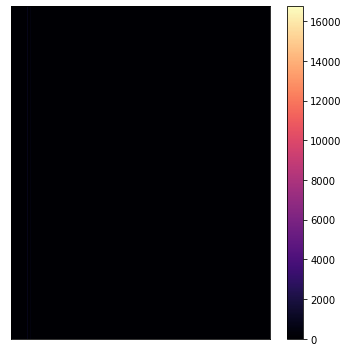

Audio sample saved!
0/3
Current Loss: 14429.706583459989	Best Loss: 14429.706583459989
Current LR: 1
Grads Average: -1.2092777356103535
Model saved!


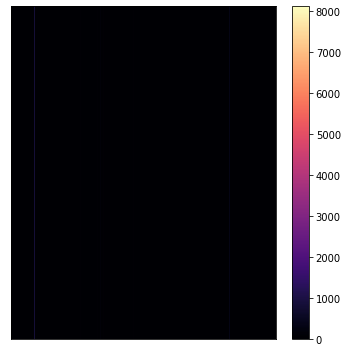

Audio sample saved!
1/3
Current Loss: 87602.54853548965	Best Loss: 87602.54853548965
Current LR: 0.1
Grads Average: -1.1941901558788557
Model saved!


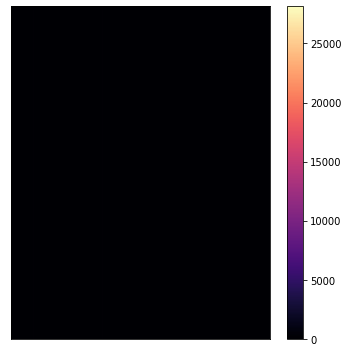

Audio sample saved!
1/3
Current Loss: 26620.2577855224	Best Loss: 26620.2577855224
Current LR: 0.1
Grads Average: -1.1941795597961513
Model saved!


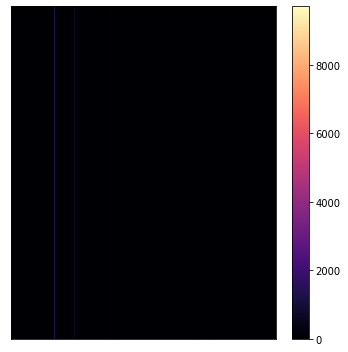

Audio sample saved!
2/3
Current Loss: 115706.10841878023	Best Loss: 115706.10841878023
Current LR: 0.010000000000000002
Grads Average: -1.1941795594297557
Model saved!


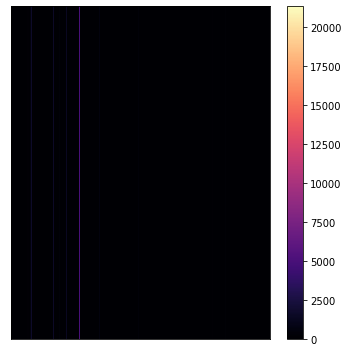

Audio sample saved!
2/3
Current Loss: 59473.1912198435	Best Loss: 59473.1912198435
Current LR: 0.010000000000000002
Grads Average: -1.1941795594295215
Model saved!


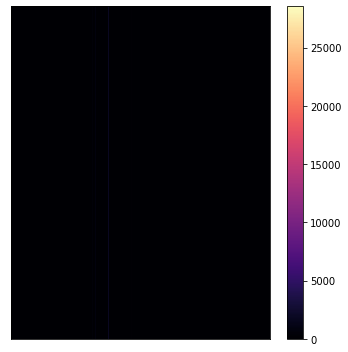

Audio sample saved!


In [109]:
train_Vagus(
    dataset=dataset,
    batch_size=1,
    epochs=3,
    checkpoint=100,
    lr=1,
    beta=1e-3,
    grad_clip=None,
    save_path=None
)

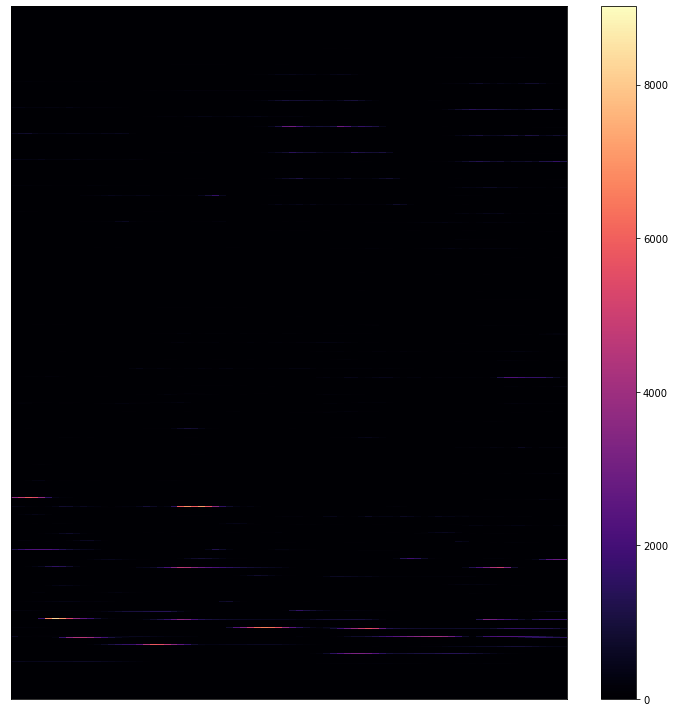

In [105]:
plt.figure(figsize=(10, 10))
display.specshow(dataset.spectrograms[0].numpy(), sr=44100)
plt.colorbar()
plt.tight_layout()

plt.show()

In [96]:
print(VGrads) ### ????

[]


In [64]:
from torch.utils import tensorboard

Talker = Vagus().to(device).double()

for name, param in Vagus.named_parameters():
    if "weight" in name:
        nn.init.normal_(param, 0, 0.01)
    
    if "bias" in name:
        nn.init.constant_(param, 0.0)

writer = tensorboard.SummaryWriter(log_dir='Vagus', comment="Testing Alice's Voice Generator")

writer.add_graph(Vagus, [torch.randn((1, 77, 1)).to(device).double(), torch.randn((1, 1333, 80).to(device).double()])

epochs=10

for epoch in range(epochs):
    for a, b, c in zip(costAudio, VLR, VGrads):

        writer.add_scalar('Vagus Loss', a, global_step=epoch)
        writer.add_scalar('Vagus Learning Rate', b[0], global_step=epoch)
        writer.add_scalar('Vagus Gradients Average', c, global_step=epoch)

writer.close()

In [131]:
import winsound

def evaluate_Vagus(
    dataset=None,
    batch_size=16,
    model_path=None
):
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    Talker = Vagus().to(device).double()

    params = torch.load(f"{model_path}/Alice_Voice_checkpoint.json")

    Talker.load_state_dict(params['Vagus_Params'])

    Talker.eval()

    _, (_, spectrogram, text) = next(enumerate(dataloader))

    spectrogram = spectrogram.to(device)
    text = text.to(device)

    sample_audio = Talker(text, spectrogram)

    plt.figure(figsize=(10, 10))
    display.specshow(sample_audio[0].detach().cpu().numpy(), sr=44100)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    Audio(sample_audio[0].detach().cpu(), rate=44100)

    torchaudio.save(f'{model_path}/Alice_Voice_sample.wav', sample_audio[0].detach().cpu(), sample_rate=44100, channels_first=True)
    winsound.PlaySound(f'{model_path}/Alice_Voice_sample.wav', winsound.SND_FILENAME)

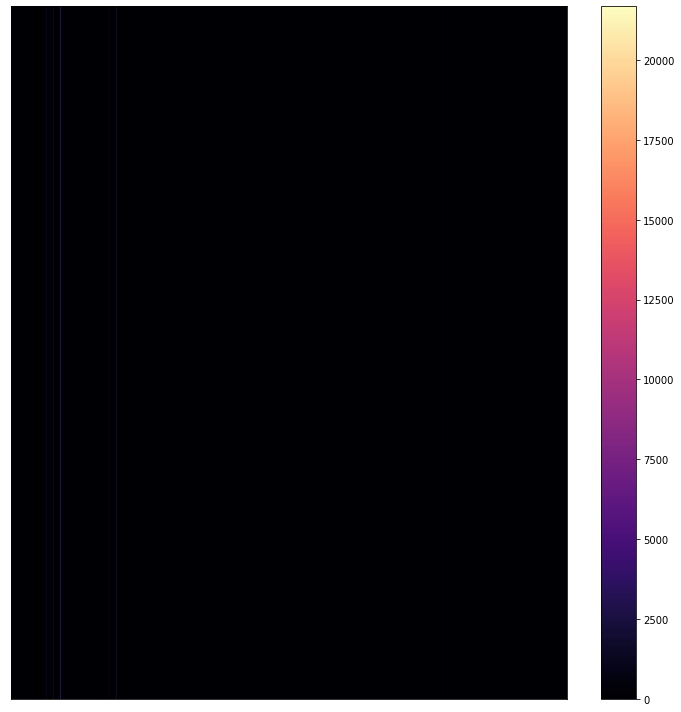

In [132]:
evaluate_Vagus(dataset=dataset, batch_size=1, model_path="Alice")